# Implementing a neural network in low-level tensorflow with eager execution

This notebook implements a simple multilayer perceptron for the Boston Housing data. First we set up tensorflow for eager execution.

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Now we get the Boston Housing data, normalise it and reshape the outputs into 2-dimensional tensors (which are required because they must match our `pred` tensor which is 2-dimensional as noted above).

In [2]:
# Download data
import numpy as np
from keras.datasets import boston_housing
(x_train, y_train), (x_val, y_val) = boston_housing.load_data()
# Normalise data
x_mean = np.std(x_train, 0)
x_sd = np.std(x_train, 0)
for i in range(13):
    x_train[:,i] -= x_mean[i]
    x_train[:,i] /= x_sd[i]
    x_val[:,i] -= x_mean[i]
    x_val[:,i] /= x_sd[i]
# Reshape data
y_train = y_train.reshape((404,1))
y_val = y_val.reshape((102,1))

Using TensorFlow backend.


Let's split the data into batches.

In [3]:
nbatches = 10
xbatches = np.array_split(x_train, nbatches)
ybatches = np.array_split(y_train, nbatches)

Next we create the variables we are going to use. Their shapes depend on the architecture of our network so we also specify this.

In [4]:
ninputs = x_train.shape[1]
layer_sizes = [5, 3, 1] # nb the last layer is the output
biases = [tfe.Variable(np.random.normal(scale=0.05, size=n), dtype=tf.float32) for n in layer_sizes]
weight_dims = zip([ninputs]+layer_sizes[0:-1], layer_sizes) # list of tuples giving dimensions for weight matrices
weights = [tfe.Variable(np.random.normal(scale=0.05, size=s), dtype=tf.float32) for s in weight_dims]
variables = biases+weights

Now we create a function which performs a forward evaluation of the neural network. I'm using the tanh activation function for the intermediate layers as this small neural network is especially vulnerable to dead ReLUs. For the final layer I use a softplus activation function to ensure the output is positive.

In [5]:
def get_preds(x, sizes=[5,3]):
    inputs = tf.constant(x, dtype=tf.float32)
    layer1 = tf.nn.tanh(tf.matmul(inputs, weights[0]) + biases[0])
    layer2 = tf.nn.tanh(tf.matmul(layer1, weights[1]) + biases[1])
    preds = tf.nn.softplus(tf.matmul(layer2, weights[2]) + biases[2])
    return preds

Note that the output of `get_preds` ends up being a 2-dimensional tensor, although it has only 1 column.

In [6]:
preds = get_preds(xbatches[0])
print(preds)

Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor(
[[0.6928331 ]
 [0.69509375]
 [0.69401705]
 [0.6928672 ]
 [0.6931503 ]
 [0.69316626]
 [0.69324255]
 [0.69390005]
 [0.6945656 ]
 [0.69255024]
 [0.69335556]
 [0.6939189 ]
 [0.69379294]
 [0.6932428 ]
 [0.69303864]
 [0.69730777]
 [0.69415253]
 [0.6949626 ]
 [0.69519097]
 [0.69308454]
 [0.69534343]
 [0.6942659 ]
 [0.69472915]
 [0.6943555 ]
 [0.69294465]
 [0.69329786]
 [0.69401526]
 [0.69358885]
 [0.6929528 ]
 [0.69317174]
 [0.6943131 ]
 [0.6931586 ]
 [0.6933645 ]
 [0.6928399 ]
 [0.6942925 ]
 [0.6930908 ]
 [0.6929938 ]
 [0.69295186]
 [0.6931173 ]
 [0.69337535]
 [0.69325256]], shape=(41, 1), dtype=float32)


We'll use mean squared error loss which can be implemented in Tensorflow as follows.

In [7]:
tf.reduce_mean(tf.square(preds - ybatches[0]))

<tf.Tensor: id=64, shape=(), dtype=float32, numpy=527.35754>

The following functions evaluate the loss and the its gradient.

In [8]:
def get_loss(x, y):
    return tf.reduce_mean(tf.square(get_preds(x) - y))

In [9]:
def get_loss_and_grads(x, y):
    with tf.GradientTape() as tape:
        loss = get_loss(x, y)
    return loss, tape.gradient(loss, variables)

Next we create our optimiser.

In [10]:
optimiser = tf.train.AdamOptimizer()

Finally we can train the neural network.

In [11]:
for e in range(1, 5000):
  train_loss = 0.
  for (x, y) in zip(xbatches, ybatches):
      next_loss, grads = get_loss_and_grads(x, y)
      optimiser.apply_gradients(zip(grads, variables))
      train_loss += next_loss
  if e % 250 == 0:
    train_loss /= nbatches
    val_loss = get_loss(x_val, y_val)
    print("Epochs {:3d} Train loss {:.1f} Validation loss {:.1f}".format(e, train_loss, val_loss))

Epochs 250 Train loss 230.4 Validation loss 245.5
Epochs 500 Train loss 108.5 Validation loss 114.1
Epochs 750 Train loss 85.1 Validation loss 85.2
Epochs 1000 Train loss 42.5 Validation loss 44.3
Epochs 1250 Train loss 21.9 Validation loss 27.8
Epochs 1500 Train loss 12.8 Validation loss 22.5
Epochs 1750 Train loss 8.3 Validation loss 21.9
Epochs 2000 Train loss 6.3 Validation loss 22.6
Epochs 2250 Train loss 5.6 Validation loss 23.0
Epochs 2500 Train loss 5.4 Validation loss 23.1
Epochs 2750 Train loss 5.2 Validation loss 23.1
Epochs 3000 Train loss 5.1 Validation loss 23.1
Epochs 3250 Train loss 5.1 Validation loss 23.1
Epochs 3500 Train loss 5.0 Validation loss 23.2
Epochs 3750 Train loss 4.9 Validation loss 23.6
Epochs 4000 Train loss 4.8 Validation loss 23.9
Epochs 4250 Train loss 4.7 Validation loss 24.0
Epochs 4500 Train loss 4.7 Validation loss 24.0
Epochs 4750 Train loss 4.6 Validation loss 23.9


This run has achieved much better training loss than for linear regression and a similar validation loss - compare with Figure 2.1 of the notes. The difference between training and validation loss suggests significant overfitting. (On other training runs the evidence is even stronger due to a large validation loss!)

Let's look at our predictions.

In [12]:
predictions_train = get_preds(x_train)
predictions_val = get_preds(x_val)

In [13]:
import matplotlib.pyplot as plt

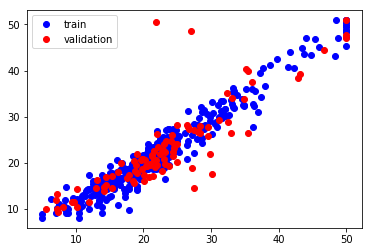

In [14]:
plt.plot(y_train, predictions_train, "bo", label="train")
plt.plot(y_val, predictions_val, "ro", label="validation")
plt.legend()

The training predictions look significantly improved compared to the linear regression values in Figure 2.2. One improvement is that we've prevented any negative predictions by using a softplus activation. Another is that house values close to 50 are no longer badly underestimated.

On the other hand the validation predictions contain several outlying predictions corroborating the earlier suspicion of overfitting. Regularisation of some sort would probably improve validation loss.

This example illustrates that neural networks can improve on linear regression even for small datasets. However the major benefits are for big datasets!